<a href="https://colab.research.google.com/github/vedantdave77/Udacity_Nueral_network_pytorch/blob/master/Mini_Project_MNIST_Py_Torch_(drop_out_effect_on_model_strength).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [0]:
# import libraries
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

0it [00:00, ?it/s]

9920512it [00:05, 1832742.88it/s]                             


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


32768it [00:00, 317749.27it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 5261313.69it/s]                           
8192it [00:00, 127760.34it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

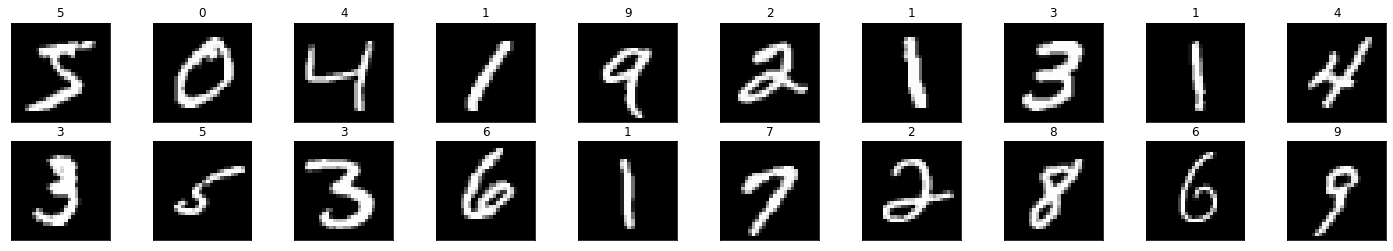

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

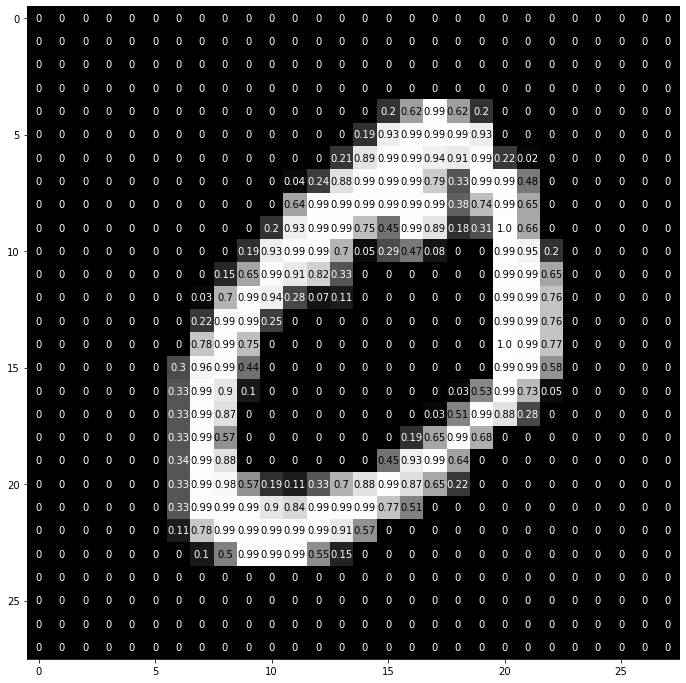

In [18]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

# MODEL 1 WITH LOWER DROP OUT

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [27]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hid_layer1 =512
        hid_layer2 = 128
        # linear layer (784 -> 1 hidden node)
        self.fc1 = nn.Linear(28 * 28, hid_layer1)
        self.fc2 = nn.Linear(hid_layer1, hid_layer2)
        self.fc3 = nn.Linear(hid_layer2,10)
        self.dropout = nn.Dropout(0.2)
        

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        self.dropout(x)
        x  =F.relu(self.fc2(x))
        self.dropout(x)
        x = F.log_softmax(self.fc3(x))
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [0]:
## TODO: Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(),lr= 0.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [29]:
# number of epochs to train the model
n_epochs = 30  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 0.813509
Epoch: 2 	Training Loss: 0.302296
Epoch: 3 	Training Loss: 0.239578
Epoch: 4 	Training Loss: 0.197694
Epoch: 5 	Training Loss: 0.166418
Epoch: 6 	Training Loss: 0.142360
Epoch: 7 	Training Loss: 0.123308
Epoch: 8 	Training Loss: 0.107870
Epoch: 9 	Training Loss: 0.095102
Epoch: 10 	Training Loss: 0.084433
Epoch: 11 	Training Loss: 0.075445
Epoch: 12 	Training Loss: 0.067739
Epoch: 13 	Training Loss: 0.061088
Epoch: 14 	Training Loss: 0.055286
Epoch: 15 	Training Loss: 0.050220
Epoch: 16 	Training Loss: 0.045681
Epoch: 17 	Training Loss: 0.041637
Epoch: 18 	Training Loss: 0.038010
Epoch: 19 	Training Loss: 0.034752
Epoch: 20 	Training Loss: 0.031807
Epoch: 21 	Training Loss: 0.029103
Epoch: 22 	Training Loss: 0.026684
Epoch: 23 	Training Loss: 0.024455
Epoch: 24 	Training Loss: 0.022408
Epoch: 25 	Training Loss: 0.020569
Epoch: 26 	Training Loss: 0.018883
Epoch: 27 	Training Loss: 0.017368
Epoch: 28 	Training Loss: 0.015980
Epoch: 29 	Training Loss: 0.0

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [30]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 0.063412

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1126/1135)
Test Accuracy of     2: 98% (1013/1032)
Test Accuracy of     3: 97% (989/1010)
Test Accuracy of     4: 98% (966/982)
Test Accuracy of     5: 97% (870/892)
Test Accuracy of     6: 97% (936/958)
Test Accuracy of     7: 97% (998/1028)
Test Accuracy of     8: 96% (944/974)
Test Accuracy of     9: 97% (986/1009)

Test Accuracy (Overall): 97% (9799/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


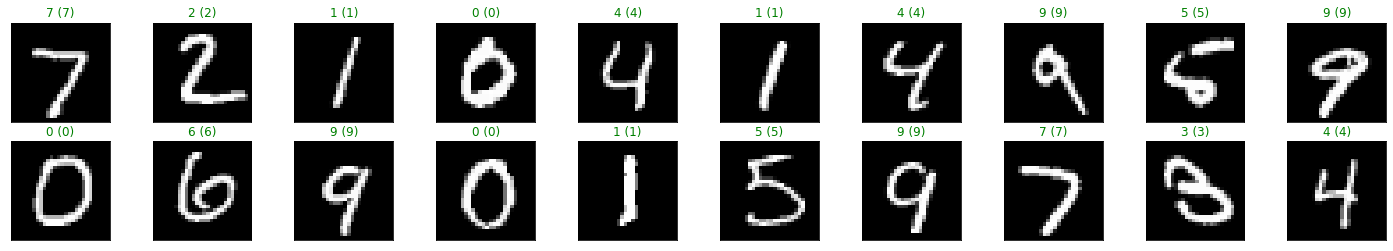

In [31]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [0]:
# The end of first nomal model

# MODEL 2 WITH HIGHER DROP OUT ( WE WILL SEE THAT THE TRAIN DATA INCREASE AND WELL TRAINTED BUT ON THE OTHER END TEST RESULT DEECTREASE SO MODEL WILL OVERFIT)

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hid_layer1 =512
        hid_layer2 = 128
        # linear layer (784 -> 1 hidden node)
        self.fc1 = nn.Linear(28 * 28, hid_layer1)
        self.fc2 = nn.Linear(hid_layer1, hid_layer2)
        self.fc3 = nn.Linear(hid_layer2,10)
        self.dropout = nn.Dropout(0.4)
        

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        self.dropout(x)
        x  =F.relu(self.fc2(x))
        self.dropout(x)
        x = F.log_softmax(self.fc3(x))
        return x

# initialize the NN
model1 = Net()
print(model1)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [0]:
# specify loss function
criterion1 = nn.CrossEntropyLoss()

# specify optimizer
optimizer1 = torch.optim.SGD(model1.parameters(),lr= 0.01)

In [37]:
n_epochs = 30  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss1 = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer1.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output1 = model1(data)
        # calculate the loss
        loss1 = criterion1(output1, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss1.backward()
        # perform a single optimization step (parameter update)
        optimizer1.step()
        # update running training loss
        train_loss1 += loss1.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss1 = train_loss1/len(train_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss1
        ))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 0.799606
Epoch: 2 	Training Loss: 0.303259
Epoch: 3 	Training Loss: 0.243980
Epoch: 4 	Training Loss: 0.201216
Epoch: 5 	Training Loss: 0.168859
Epoch: 6 	Training Loss: 0.144052
Epoch: 7 	Training Loss: 0.124627
Epoch: 8 	Training Loss: 0.109002
Epoch: 9 	Training Loss: 0.096212
Epoch: 10 	Training Loss: 0.085525
Epoch: 11 	Training Loss: 0.076430
Epoch: 12 	Training Loss: 0.068683
Epoch: 13 	Training Loss: 0.061970
Epoch: 14 	Training Loss: 0.056150
Epoch: 15 	Training Loss: 0.051034
Epoch: 16 	Training Loss: 0.046493
Epoch: 17 	Training Loss: 0.042472
Epoch: 18 	Training Loss: 0.038872
Epoch: 19 	Training Loss: 0.035602
Epoch: 20 	Training Loss: 0.032638
Epoch: 21 	Training Loss: 0.029942
Epoch: 22 	Training Loss: 0.027485
Epoch: 23 	Training Loss: 0.025229
Epoch: 24 	Training Loss: 0.023173
Epoch: 25 	Training Loss: 0.021304
Epoch: 26 	Training Loss: 0.019571
Epoch: 27 	Training Loss: 0.018024
Epoch: 28 	Training Loss: 0.016606
Epoch: 29 	Training Loss: 0.0

In [40]:
test_loss1 = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model1.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output1 = model(data)
    # calculate the loss
    loss1 = criterion(output1, target)
    # update test loss 
    test_loss1 += loss1.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss1 = test_loss1/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss1))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Test Loss: 0.063412

Test Accuracy of     0: 16% (162/980)
Test Accuracy of     1: 14% (166/1135)
Test Accuracy of     2:  5% (56/1032)
Test Accuracy of     3:  3% (37/1010)
Test Accuracy of     4: 13% (137/982)
Test Accuracy of     5: 10% (94/892)
Test Accuracy of     6:  5% (55/958)
Test Accuracy of     7: 10% (108/1028)
Test Accuracy of     8:  0% ( 0/974)
Test Accuracy of     9: 21% (220/1009)

Test Accuracy (Overall): 10% (1035/10000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


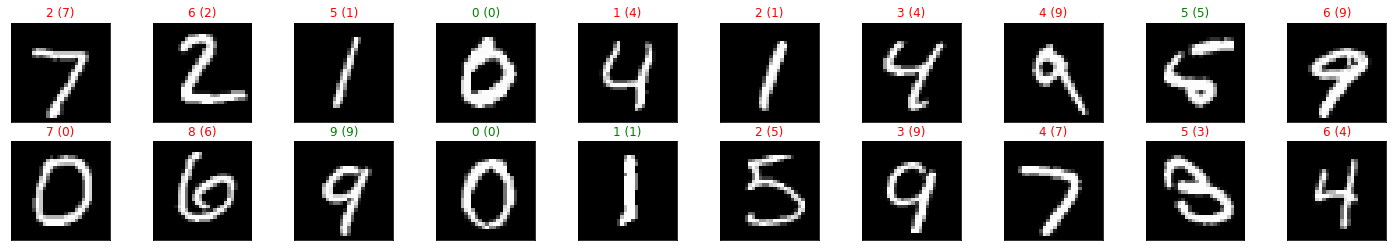

In [41]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model1(images)
# convert output probabilities to predicted class
_, preds = torch.max(output1, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## REASON;
### Main reason for such behaviour is due to more drop out , in such cases model have not good enough data to discriminate or make difference between the datasets. 

### See above examples in which most of probelm is between pair of some specific no. it shows week connection of network to identify the specific part of number to identify. As an example the No 6 and 9 have the difference of direction of curve, difference between 2 and 7 has the no. of curve.

### even furthur observation related to 1 is surprising, first 1 is idetified as 5 then 2 and at last correctly 1 so main visual difference is 1 with forward or backward slope can not idetify by model1. 

### This shows the requrirement of enough data with different example's requirement to improve model confidence. 

## Thank you. Keep learning, be empowering! 